In [1]:
import mediapipe as mp
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Data Loading

In [3]:
data_path="../../data/sample_videos/sample1.mp4"

_, vid_file_name = os.path.split(data_path)
video = cv2.VideoCapture(data_path)

## Video Processing

In [2]:
def get_centroid_details(file_path):
    """This function gets pose details from mediapipe

    Args:
        file_path (string): This is the path of the video file
        visualize (bool, optional): Provides a visualization for the pose tracking. Defaults to False.

    Returns:
        dict: This dictionary contains a list of upper body pose estimates
    """
    cap = cv2.VideoCapture(file_path)
    mp_pose = mp.solutions.pose

    rh_centroid_x = []
    rh_centroid_y = []

    lh_centroid_x = []
    lh_centroid_y = []

    with mp_pose.Pose(
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_height, image_width, _ = image.shape

            centroid_results = pose.process(image)

            rh_centroid_x_frame = []
            rh_centroid_y_frame = []

            lh_centroid_x_frame = []
            lh_centroid_y_frame = []

            right_hand_coords=[16, 18, 20, 22]
            left_hand_coords=[15, 17, 21, 19]

            for i in (right_hand_coords):
                rh_centroid_x_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].x * image_width, 2)
                )
                rh_centroid_y_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].y * image_height, 2)
                )

            for i in (left_hand_coords):
                lh_centroid_x_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].x * image_width, 2)
                )
                lh_centroid_y_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].y * image_height, 2)
                )
            # calculate centroid by taking the arithmetic mean of coordinates
            rh_centroid_x.append(round(sum(rh_centroid_x_frame)/len(rh_centroid_x_frame), 2))
            rh_centroid_y.append(round(sum(lh_centroid_y_frame)/len(lh_centroid_y_frame), 2))

            lh_centroid_x.append(round(sum(lh_centroid_x_frame)/len(lh_centroid_x_frame), 2))
            lh_centroid_y.append(round(sum(lh_centroid_y_frame)/len(lh_centroid_y_frame), 2))
    cap.release()
    
    centroid={}
    centroid["right_hand_x"]=rh_centroid_x
    centroid["right_hand_y"]=rh_centroid_y
    centroid["left_hand_x"]=lh_centroid_x
    centroid["left_hand_y"]=lh_centroid_y

    return centroid

In [4]:
centroid = get_centroid_details(data_path)
initial_no_frames=len(centroid["right_hand_x"])

centroid

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


{'right_hand_x': [112.86,
  107.92,
  105.47,
  105.52,
  105.79,
  105.87,
  105.86,
  105.75,
  105.69,
  105.77,
  106.34,
  106.48,
  106.75,
  107.32,
  108.12,
  108.39,
  109.17,
  111.1,
  124.35,
  125.75,
  123.87,
  121.93,
  109.03,
  98.7,
  95.46,
  93.63,
  92.84,
  93.46,
  94.72,
  100.28,
  113.28,
  122.27,
  130.57,
  131.49,
  128.54,
  126.33,
  125.15,
  124.53,
  126.3,
  127.23,
  127.11,
  128.01,
  128.65,
  131.86,
  135.68,
  137.45,
  141.55,
  144.47,
  146.57,
  148.79,
  149.49,
  148.89,
  148.82,
  148.8,
  148.33,
  148.79,
  150.41,
  151.74,
  152.57,
  153.41,
  152.78,
  150.01,
  145.33,
  139.73,
  129.52,
  121.52,
  113.51,
  109.22,
  108.04,
  108.17,
  109.23,
  111.12,
  126.47,
  139.53,
  156.92,
  161.04,
  161.7,
  161.52,
  160.93,
  161.27,
  160.64,
  162.84,
  162.6,
  162.72,
  161.94,
  161.61,
  161.3,
  157.75,
  150.0,
  140.42,
  137.33,
  138.31,
  140.01,
  141.73,
  144.51,
  148.94,
  152.7,
  155.84,
  155.4,
  155.69,


## Calculating parameters from centroid values

Finding out the hand distance parameter for all the frames, Eqn: <br>


\begin{equation}
max(\sqrt({(x_i^l-x_{i-1}^l)}^2+{(y_i^l-y_{i-1}^l)}^2), \sqrt({(x_i^r-x_{i-1}^r)}^2+{(y_i^r-y_{i-1}^r)}^2))
\end{equation}

In [5]:
right_x = centroid["right_hand_x"]
right_y = centroid["right_hand_y"]
left_x = centroid["left_hand_x"]
left_y = centroid["left_hand_y"]

hand_distance=[]

def euc_dist(x1, x2, y1, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

for i in range(1, initial_no_frames):
    right_distance = euc_dist(right_x[i], right_x[i-1], right_y[i], right_y[i-1])
    left_distance = euc_dist(left_x[i], left_x[i-1], left_y[i], left_y[i-1])
    hand_distance.append(max(right_distance, left_distance))


Finding out the hand height parameter for all the frames, Eqn: <br>
\begin{equation}
min(y_i^l, y_i^r)
\end{equation}


In [6]:
hand_height=[]
for i in range(initial_no_frames):
    hand_height.append(min(right_y[i], left_y[i]))


Plotting the hand distance for each frame in the video file to see how the value changes. Also plotting a threshold that accepts frames that contain less than 10% hand movement comapred to the maximum hand movement

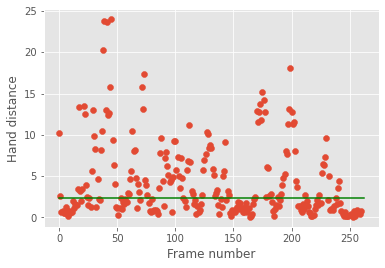

In [7]:
plt.scatter([i for i in range(0, initial_no_frames-1)], hand_distance)
alpha=round(0.1*max(hand_distance), 2)
plt.plot([0, initial_no_frames], [alpha, alpha], color="green")

plt.ylabel("Hand distance")
plt.xlabel("Frame number")
plt.show()


Plotting the hand height for each frame in the video file to see how the value changes. Also plotting a line through the average of hand height values to represent a threshold to select the frames

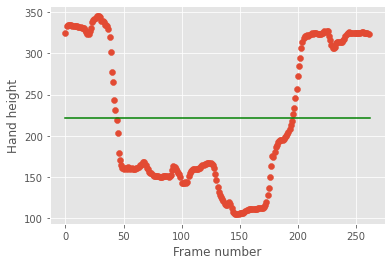

In [8]:
plt.scatter([i for i in range(0, initial_no_frames)], hand_height)
beta=round(sum(hand_height)/len(hand_height), 2)
plt.plot([0, initial_no_frames], [beta, beta], color="green")


plt.ylabel("Hand height")
plt.xlabel("Frame number")
plt.show()

Using the computed thresholds to output the processed video file, which will not include frames that are not passing the threshold values

In [9]:
video = cv2.VideoCapture(data_path)
output_path = os.path.join("../output/", vid_file_name.split(".")[0] + ".mp4")
fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
dim=(int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(video.get(cv2.CAP_PROP_FRAME_WIDTH)))
output = cv2.VideoWriter(output_path, fourcc, video.get(cv2.CAP_PROP_FPS), dim)

frame_num=0
output_frames=0
while True:
    ret, frame = video.read()
    if not ret:
        break
    if(hand_distance[frame_num-1]>alpha and frame_num!=0):
        output.write(frame)
        output_frames+=1
    elif(hand_height[frame_num]<beta):
        output.write(frame)
        output_frames+=1
    frame_num+=1
output.release()


Creating video summary dictionary to store the video metadata

In [10]:
video_summary={}
video_summary["Filename"]=vid_file_name
video_summary["Hand_Height"]=hand_height
video_summary["Hand_Distance"]=hand_distance
video_summary["Initial_Frame_Count"]=initial_no_frames
video_summary["Post_KFS_Frame_Count"]=output_frames
video_summary["Percentage_Reduction"]=round(((initial_no_frames-output_frames)/initial_no_frames)*100, 2)
video_summary["Hand_Height_Threshold_Value"]=beta
video_summary["Hand_Distance_Threshold_Value"]=alpha

output_path = os.path.join("../output/", vid_file_name.split(".")[0] + ".json")

with open(output_path, "w") as f:
    f.write(json.dumps(video_summary))

video_summary

{'Filename': 'sample1.mp4',
 'Hand_Height': [324.49,
  333.43,
  334.44,
  334.81,
  334.13,
  333.76,
  333.44,
  333.25,
  333.1,
  333.0,
  332.88,
  332.31,
  332.11,
  331.27,
  330.73,
  330.68,
  330.54,
  328.23,
  326.26,
  323.33,
  323.81,
  326.64,
  330.68,
  337.74,
  339.86,
  341.47,
  342.45,
  344.69,
  344.89,
  344.66,
  343.57,
  339.64,
  338.96,
  338.15,
  334.51,
  334.62,
  333.48,
  329.89,
  320.12,
  301.64,
  277.9,
  265.03,
  242.84,
  230.8,
  218.72,
  203.03,
  179.37,
  170.41,
  164.37,
  160.96,
  159.94,
  160.93,
  160.7,
  159.63,
  161.84,
  161.14,
  160.22,
  161.08,
  159.64,
  159.62,
  160.4,
  161.06,
  161.59,
  161.75,
  164.1,
  164.48,
  166.31,
  168.41,
  168.2,
  164.17,
  161.24,
  160.24,
  156.34,
  154.55,
  154.89,
  153.06,
  151.85,
  151.1,
  151.12,
  151.11,
  151.08,
  150.69,
  150.64,
  150.72,
  151.24,
  151.38,
  151.6,
  150.93,
  150.89,
  149.64,
  151.0,
  152.03,
  159.07,
  163.59,
  161.96,
  160.11,
  157.92

## Insights and Summary


Two parameters were calculated and keyframe selection was done using them. In this task, I used 2 methods to automatically calculate a threshold for any particular video.

For the hand distance, the frames between which the hand distances were small, are very similar and do not contribute anything of value. These values needed to be removed. On plotting the hand distance vs no. of frame graph, it was clear that we could remove most of the lower values. I removed the unwanted frames by taking a threshold of 10% of the maximum hand distance.

For the hand height, on plotting it, it was clear that there were periods during the beginning and ending part of the video, that the hands stayed at a particular height. So, I decided to go with an average of all the values. I felt like this should give a value somewhere in the middle, and we would be able to remove most of the redundant frames.